# Advanced Time Series Analysis

This notebook explores the fundamental concepts and advanced techniques in time series analysis, including trends, seasonality, cyclic patterns, and randomness. We will also cover decomposition techniques and hands-on exercises using Python libraries.

In [19]:
# import requests
!pip install openmeteo-requests requests-cache retry-requests

   ---------------------------------------- 0.0/61.4 kB ? eta -:--:--
   ---------------------------------------- 61.4/61.4 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/66.4 kB ? eta -:--:--
   ---------------------------------------- 66.4/66.4 kB 1.8 MB/s eta 0:00:00


## 1. Import Required Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
import requests

## 2. Key Concepts in Time Series Analysis

### 2.1 Trend
A trend is the long-term increase or decrease in the data. It does not repeat and is usually caused by external factors, such as population growth or technology advancements.

### 2.2 Seasonality
Seasonality refers to patterns that repeat at regular intervals, such as daily, monthly, or yearly.

### 2.3 Cyclic Patterns
Cyclic patterns are fluctuations that occur at irregular intervals and are usually related to economic or business cycles.

### 2.4 Randomness
Randomness refers to the unpredictable component in a time series that cannot be modeled using trends, seasonality, or cyclic patterns.

## 3. Fetch Weather Data for Analysis

In [27]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 28.6519,
	"longitude": 77.2315,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "wind_speed_10m", "soil_temperature_6cm"],
	"daily": ["temperature_2m_max", "daylight_duration", "uv_index_clear_sky_max"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_soil_temperature_6cm = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["soil_temperature_6cm"] = hourly_soil_temperature_6cm


weather_data = pd.DataFrame(data = hourly_data)
# print(hourly_dataframe)
weather_data.head(2)

Coordinates 28.625°N 77.25°E
Elevation 231.0 m asl
Timezone b'Asia/Kolkata' b'IST'
Timezone difference to GMT+0 19800 s


,date,temperature_2m,relative_humidity_2m,rain,wind_speed_10m,soil_temperature_6cm
0,2022-12-31 18:30:00+00:00,10.5505,91.0,0.0,3.319036,11.6005
1,2022-12-31 19:30:00+00:00,10.0505,93.0,0.0,3.259938,11.2005


In [30]:
weather_data.tail()

,date,temperature_2m,relative_humidity_2m,rain,wind_speed_10m,soil_temperature_6cm
8755,2023-12-31 13:30:00+00:00,17.450500,70.0,0.0,2.968636,17.100500
8756,2023-12-31 14:30:00+00:00,16.400499,74.0,0.0,2.968636,15.900499
8757,2023-12-31 15:30:00+00:00,15.550500,77.0,0.0,2.968636,15.050500
8758,2023-12-31 16:30:00+00:00,14.800500,79.0,0.0,3.415260,14.350500
8759,2023-12-31 17:30:00+00:00,14.150500,81.0,0.0,3.415260,13.750500


## 4. Visualize the Time Series Data

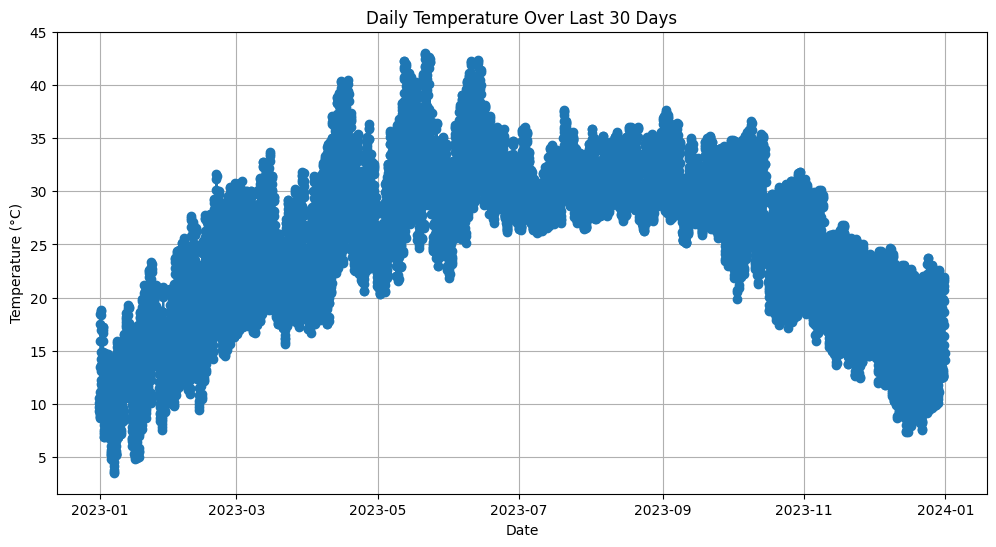

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(weather_data['date'], weather_data['temperature_2m'], marker='o')
plt.title('Daily Temperature Over Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

## 5. Time Series Decomposition

In [ ]:
decomposition = seasonal_decompose(weather_data['temperature'], period=7, model='additive')

# Plot decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

## 6. Basic Statistics

In [ ]:
mean_temp = weather_data['temperature'].mean()
variance_temp = weather_data['temperature'].var()
std_dev_temp = weather_data['temperature'].std()

print(f"Mean Temperature: {mean_temp:.2f}°C")
print(f"Variance in Temperature: {variance_temp:.2f}")
print(f"Standard Deviation: {std_dev_temp:.2f}")

## 7. Moving Averages and Smoothing

In [ ]:
weather_data['moving_avg'] = weather_data['temperature'].rolling(window=5).mean()

# Plot with moving average
plt.figure(figsize=(12, 6))
plt.plot(weather_data['date'], weather_data['temperature'], label='Daily Temperature', marker='o')
plt.plot(weather_data['date'], weather_data['moving_avg'], label='5-Day Moving Average', color='orange', linewidth=2)
plt.title('Temperature and Moving Average')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()